In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

In [2]:
# Set constants of model
e    = 0.3      # dimensionless electron charge
F    = 1e11     # pi-axion decay constant (GeV)
p_t  = 0.4      # total local DM density (GeV/cm^3)

## Tuneable constants
# millicharge, vary to enable/disable charged species (10e-15 = OFF, 10e-25 = ON)
#eps  = 1e-25   # (unitless)
eps  = 1

# Coupling constants
L3   = 1e11    # (GeV)
L4   = 1e11    # (GeV)
l1   = 1       #
l2   = 1       #
l3   = 1       #
l4   = 1       #

# Unit scaling:
GeV  = 1e9     # GeV -> eV
F   *= GeV
p_t *= GeV
L3  *= GeV
L4  *= GeV

In [3]:
# Initial Conditions
A_0    = 0.1
Adot_0 = 0
A_pm   = +1      # specify A± case (+1 or -1)

In [4]:
# Parameters of model

# masses for real, complex, and charged species in range (10e-8, 10e-4)
m    = [1, 3, 5]   # 10e-8 eV

# local DM densities/amplitudes for each species
p    = np.array([1/3, 1/3, 1/3]) * p_t
amps = [np.sqrt(2 * p[i]) / m[i] for i in range(len(m))]

# local phases for each species (to be sampled)
d    = [0, 0, 0]   # (0, 2pi)
d_sample = True

# global phase for neutral complex species (to be sampled)
Th   = [0, 0, 0]   # (0, 2pi)
Th_sample = True

In [5]:
# Sample phases from normal distribution, between 0 and 2pi

mu  = np.pi      # mean
sig = np.pi / 3  # standard deviation

# Modulo 2pi to ensure value is within range
if d_sample:
    for d_i in d:
        d_i = np.mod(np.random.normal(mu, sig), 2*np.pi)
if Th_sample:
    for Th_i in Th:
        Th_i = np.mod(np.random.normal(mu, sig), 2*np.pi)

In [6]:
# TODO: Finish defining time-dependent functions P(t), B(t), C(t), D(t) here
#       Verify they are the correct form, especially signs and factors of 2
# NOTE: Using cosine definitons for amplitudes
#       i = {0,1,2} correspond to {pi_0, pi, pi_+/-} respectively
def P(t):
    return 4*l3/(L3**2) * eps**2 * (np.abs(amps[2])**2 * np.cos(m[2]*t + d[2])**2) + \
           4*l4/(L4**2) * eps**2 * (np.abs(amps[1])**2 * np.cos(m[1]*t + d[1])**2 + \
                                    np.abs(amps[0])**2 * np.cos(m[0]*t + d[0])**2 + \
                                    2*np.abs(amps[0])*np.abs(amps[1]) * np.cos(m[0]*t + d[0])*np.cos(m[1]*t + d[1]) * np.cos(Th[1]))

def B(t):
    return (-1)*8*l3/(L3**2) * eps**2 * (np.abs(amps[2])**2 * m[2] * np.sin(m[2]*t + d[2])**2 * np.cos(m[2]*t + d[2])**2) + \
           (-1)*8*l4/(L4**2) * eps**2 * (np.abs(amps[0])**2 * m[0] * np.sin(m[0]*t + d[0])**2 * np.cos(m[0]*t + d[0])**2 + \
                                         np.abs(amps[1])**2 * m[1] * np.sin(m[1]*t + d[1])**2 * np.cos(m[1]*t + d[1])**2 + \
                                         np.abs(amps[1])*np.abs(amps[0]) * np.cos(Th[1]) * \
                                            (m[0] * np.sin(m[0]*t + d[0])**2 * np.cos(m[1]*t + d[1])**2 + \
                                             m[1] * np.sin(m[1]*t + d[1])**2 * np.cos(m[0]*t + d[0])**2))

def C(t):
    return (-1) * A_pm * (2*l1 / F * eps**2) * np.abs(amps[0]) * m[0] * np.sin(m[0]*t + d[0])

def D(t):
    return 2*l2 * eps**2 * e**2 * np.abs(amps[2])**2 * np.cos(m[2]*t + d[2])**2

In [7]:
# Define the system of ODEs
def system(t, y, k):
    dy0dt = y[1]
    dy1dt = -1/(1 + P(t)) * (B(t)*y[1] + (C(t)*k + D(t))*y[0]) - k**2*y[0]
    return [dy0dt, dy1dt]

# Initial conditions
y0 = [A_0, Adot_0]

# Time domain
t_span = [0, 10]  # TODO: replace with the appropriate values

# k values
k_values, step_size = np.linspace(1, 200, 200, retstep=True)  # TODO: replace with the appropriate values
#k_values = np.linspace(1./100, 10, 100)

# Initialize an array to store the solutions
t = np.linspace(t_span[0], t_span[1], 500)         # Array of times at which to evaluate
solutions = np.zeros((len(k_values), 2, len(t)))   # Array of solutions for mode k at time t

In [8]:
# Solve the differential equation for each k
def solve_system(i,k):
    sol = solve_ivp(system, t_span, y0, args=(k,), dense_output=True)

    # Evaluate the solution at the times in the array
    y = sol.sol(t)

    # Store the solution
    solutions[i] = y

    # `solutions` contains the solutions for A(t) for each k.
    # e.g. `solutions[i]` is the solution for `k_values[i]`.

#%timeit for i, k in enumerate(k_values): solve_system(i,k)
for i, k in enumerate(k_values): solve_system(i,k)

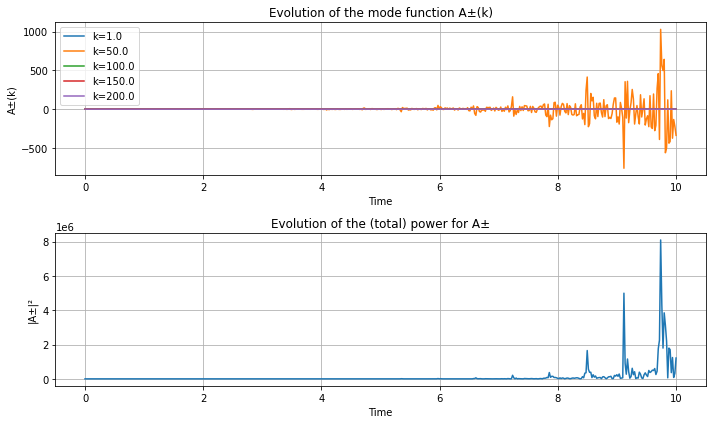

In [14]:
# Plot the solution
signstr = {1: "+", -1: "-", 0: "±"}
#k_samples = np.geomspace(1,len(k_values),num=5)
k_samples = [i for i, k_i in enumerate(k_values) if k_i in [1,50,100,150,200]]
times = t

plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
for k_sample in k_samples:
    k_s = int(k_sample)
    #print(solutions[k_s, 0])
    plt.plot(times, solutions[k_s, 0], label='k='+str(k_values[k_s]))
plt.title('Evolution of the mode function A'+signstr[0]+'(k)')
plt.xlabel('Time')
plt.ylabel('A'+signstr[0]+'(k)')
#plt.yscale('log')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(times, [sum([np.abs(solutions[i,0,t_i])**2 for i in range(len(k_values))]) for t_i in range(len(times))])
plt.title('Evolution of the (total) power for A'+signstr[0])
plt.xlabel('Time')
plt.ylabel('|A'+signstr[0]+'|²')
#plt.yscale('log')
plt.grid()

plt.tight_layout()
plt.show()

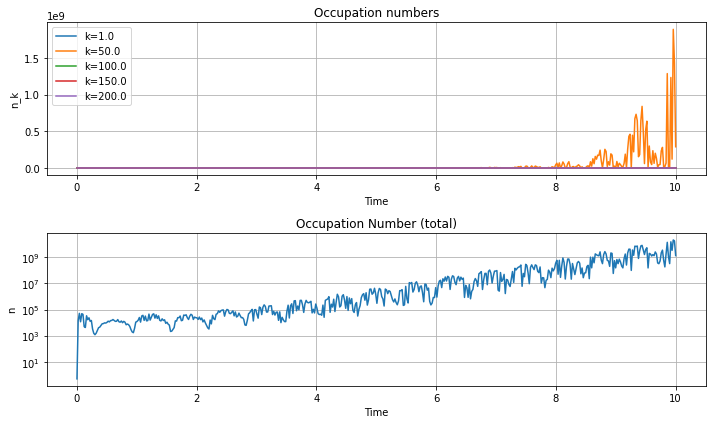

In [13]:
# Plot the occupation numbers
w = lambda i: np.abs(k_values[i])
n = lambda i: (w(i)/2) * (((np.square(np.abs(solutions[i,1])))/(np.square(w(i)))) + np.square(np.abs(solutions[i,0]))) - (1/2)

#k_samples = np.geomspace(1,len(k_values),num=5)
k_samples = [i for i, k_i in enumerate(k_values) if k_i in [1,50,100,150,200]]
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
for k_sample in k_samples:
    k_s = int(k_sample)
    plt.plot(times, n(k_s), label='k='+str(k_values[k_s]))
plt.title('Occupation numbers')
plt.xlabel('Time')
plt.ylabel('n_k')
#plt.yscale('log')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(times, [sum([n(i)[t_i] for i in range(len(k_values))]) for t_i in range(len(times))])
plt.title('Occupation Number (total)')
plt.xlabel('Time')
plt.ylabel('n')
plt.yscale('log')
plt.grid()

plt.tight_layout()
plt.show()